# Author: Sevendi Eldrige Rifki Poluan

In [99]:
!nvidia-smi

Sat May 20 21:41:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   47C    P8    38W / 390W |  23440MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow_datasets

# Import the required libraries

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

# Prepare the datasets

In [2]:
tfds.builder('oxford_iiit_pet:3.*.*').download_and_prepare(download_dir="./")

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2023-05-20 19:25:30.614495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22244 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [4]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [7]:
len(train_dataset), len(test_dataset)

(3680, 3669)

In [15]:
for x in train_dataset:
    print("Image default size: ", x["image"].numpy().shape)
    print("Image segmentation default size: ", x["segmentation_mask"].numpy().shape)
    break

Image default size:  (500, 500, 3)
Image segmentation default size:  (500, 500, 1)


In [17]:
print("Sample data", x)

Sample data {'file_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Sphynx_158.jpg'>, 'image': <tf.Tensor: shape=(500, 500, 3), dtype=uint8, numpy=
array([[[ 3,  3,  3],
        [ 5,  3,  4],
        [ 7,  5,  6],
        ...,
        [ 3,  1,  2],
        [ 3,  1,  2],
        [ 3,  1,  2]],

       [[ 4,  3,  1],
        [ 5,  3,  4],
        [ 5,  3,  4],
        ...,
        [ 6,  2,  3],
        [ 7,  3,  4],
        [ 8,  4,  5]],

       [[ 4,  3,  1],
        [ 5,  4,  2],
        [ 5,  3,  4],
        ...,
        [ 7,  3,  2],
        [ 8,  4,  3],
        [ 8,  4,  3]],

       ...,

       [[ 6, 10, 11],
        [ 6,  7,  9],
        [ 7,  8, 10],
        ...,
        [ 3,  4,  6],
        [ 3,  4,  6],
        [ 4,  5,  7]],

       [[ 8, 12, 13],
        [ 7,  8, 10],
        [ 8,  9, 11],
        ...,
        [ 4,  5,  9],
        [ 4,  5,  7],
        [ 4,  5,  7]],

       [[ 8, 12, 13],
        [ 7,  8, 10],
        [ 8,  9, 11],
        ...,
        [ 5,  6, 10],
 

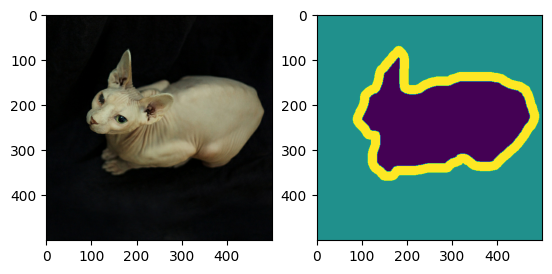

In [20]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x["image"].numpy())
plt.subplot(1, 2, 2)
plt.imshow(x["segmentation_mask"].numpy())

In [29]:
BATCH_SIZE = 32
IMG_SIZE = [256, 256]

def func(data):
    image = data["image"]
    target = data["segmentation_mask"]
    
    # resize the image
    image = tf.image.resize(image, IMG_SIZE)
    target = tf.image.resize(target, IMG_SIZE)
    
    # normalize the image
    image = tf.cast(image, tf.float32) * (1. / 255.)
    target = target - 1
    
    return image, target

train_ds = train_dataset.map(func).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_dataset.map(func).shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build the models

In [30]:
def upsample(input_to_upsample, link_to):  
    
    # Upsample the input_to_upsample using Conv2DTranspose
    up = tf.keras.layers.Conv2DTranspose(
                 link_to.shape[-2],  # sample: (None, 16, "16", 512) = 16
                 kernel_size = 3,
                 strides=(2, 2), # link_to.shape[-2] * 2
                 padding='same')(input_to_upsample) 
    
    # Concatenate the upsampled feature map with the link_to feature map
    merge = tf.keras.layers.concatenate([up, link_to], axis=3) 
    
    # Apply convolution on the merged feature map
    conv = tf.keras.layers.Conv2D(input_to_upsample.shape[-1], # sample: (None, 8, 8, "512") = 512
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    
    return merge

In [32]:
def unet(): 
    
    # I'll use VGG16 to build our base model
    base_model = tf.keras.applications.VGG16(input_shape=IMG_SIZE + [3], include_top=False)
    
    # Selects and stores the layers from the base model that have "conv1" in their names, in reverse order. 
    # I am just selecting a specific layer that will be combined (concatenated) with the final output from the VGG16 model for constructing our U-Net model.
    link_tos = [x for x in base_model.layers if "conv1" in x.name][::-1]
    
    # Set the initial upsampled value as the output of the base model
    upsampled = base_model.output
    
    # Iterate over the selected layers and perform upsampling
    for count, link in enumerate(link_tos): 
        upsampled = upsample(upsampled, link.output)
    
    # Apply a final convolutional layer to generate the model's outputs
    outputs = tf.keras.layers.Conv2D(3,  
                     kernel_size = 3,  
                     activation='softmax',
                     padding='same',
                     kernel_initializer=tf.keras.initializers.HeNormal())(upsampled)
    
    # Create the U-Net model with the base model's input as the input and the outputs from the final convolutional layer
    model = tf.keras.Model(base_model.inputs[0], outputs)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

In [33]:
unet_model = unet()

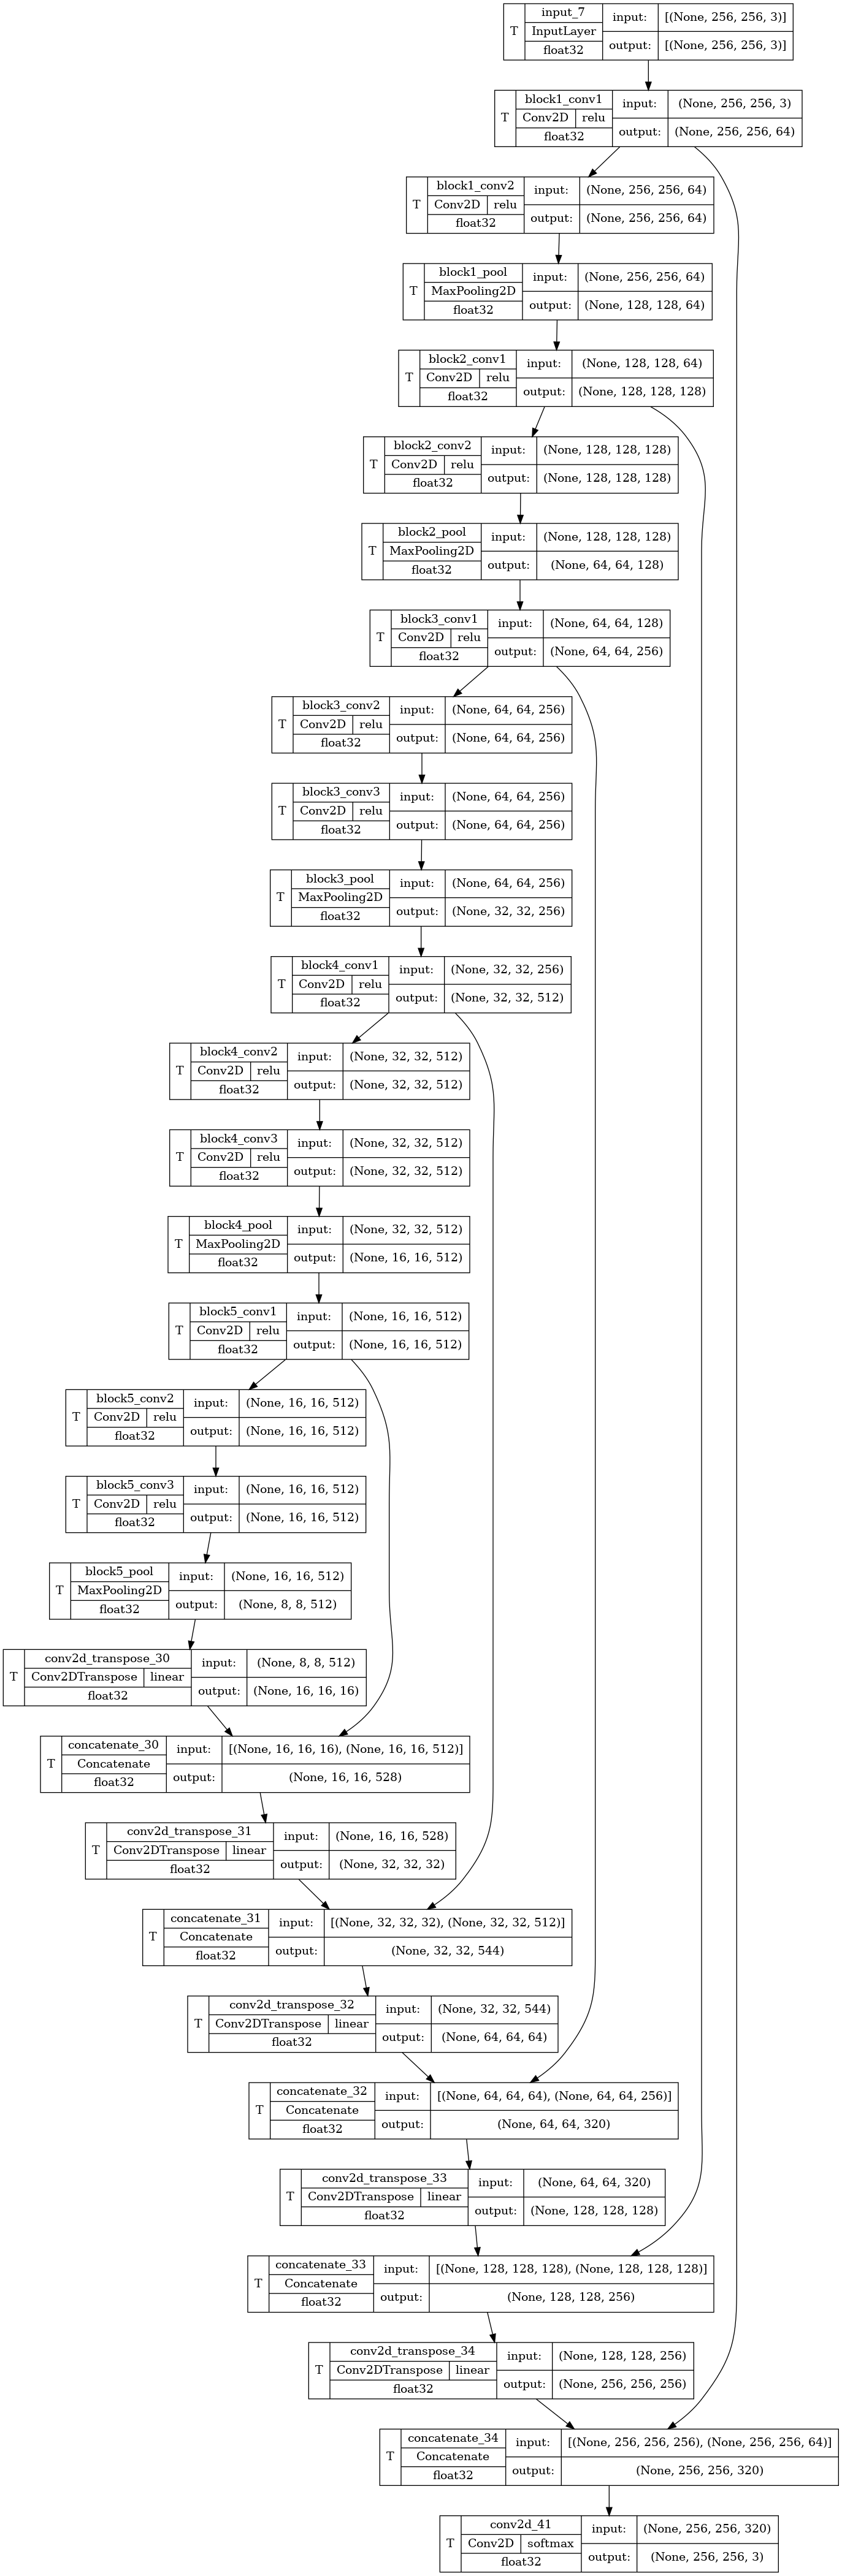

In [34]:
tf.keras.utils.plot_model(unet_model, show_dtype=True, show_shapes=True, show_layer_activations=True, show_trainable=True)

# Callbacks

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)

# Train the model

In [36]:
EPOCHS = 500
history = unet_model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds, validation_steps=len(test_ds) * .2, callbacks=[early_stopping])

Epoch 1/500


2023-05-20 19:40:26.866450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]
2023-05-20 19:40:26.867384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [4]
	 [[{{node Placeholder/_1}}]]
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


115/115 [==============================] - ETA: 0s - loss: 0.9011 - accuracy: 0.6666

2023-05-20 19:41:07.786814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]
2023-05-20 19:41:07.787179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]


115/115 [==============================] - 44s 335ms/step - loss: 0.9011 - accuracy: 0.6666 - val_loss: 0.6406 - val_accuracy: 0.7346
Epoch 2/500
115/115 [==============================] - 38s 333ms/step - loss: 0.5810 - accuracy: 0.7574 - val_loss: 0.5345 - val_accuracy: 0.7754
Epoch 3/500
115/115 [==============================] - 38s 333ms/step - loss: 0.4989 - accuracy: 0.7925 - val_loss: 0.4701 - val_accuracy: 0.8059
Epoch 4/500
115/115 [==============================] - 38s 334ms/step - loss: 0.4299 - accuracy: 0.8227 - val_loss: 0.3797 - val_accuracy: 0.8471
Epoch 5/500
115/115 [==============================] - 39s 338ms/step - loss: 0.3805 - accuracy: 0.8443 - val_loss: 0.3845 - val_accuracy: 0.8442
Epoch 6/500
115/115 [==============================] - 38s 335ms/step - loss: 0.3414 - accuracy: 0.8603 - val_loss: 0.3313 - val_accuracy: 0.8659
Epoch 7/500
115/115 [==============================] - 39s 335ms/step - loss: 0.3099 - accuracy: 0.8723 - val_loss: 0.3430 - val_accurac

In [38]:
unet_model.save_weights("Saved model/model.weights.h5")

# Evaluate the model

<Axes: >

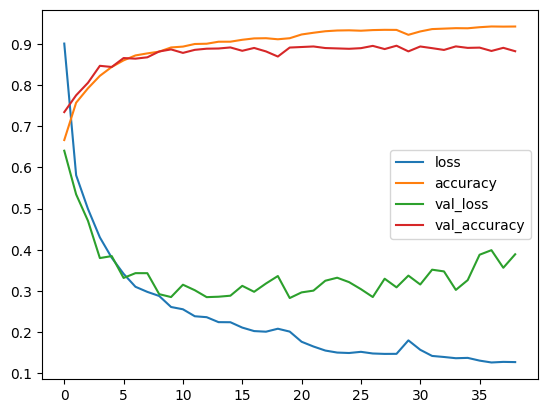

In [40]:
pd.DataFrame(history.history).plot()

In [43]:
test_performance = unet_model.evaluate(test_ds)
print("Testing accurracy: ", test_performance[1])

115/115 [==============================] - 14s 118ms/step - loss: 0.4023 - accuracy: 0.8807
Testing accurracy:  0.8807401061058044


# Print some sample results

In [70]:
prediction_results.shape

(32, 256, 256, 3)

1/1 [==============================] - 0s 29ms/step


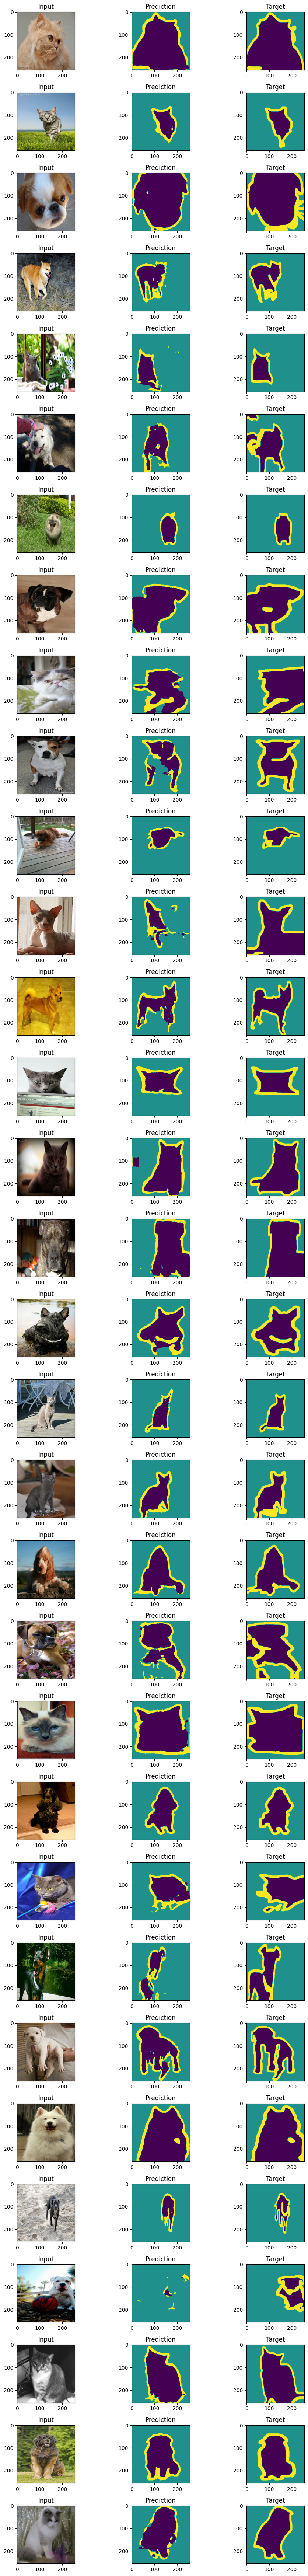

In [97]:
# Create subplots with 32 rows and 3 columns, adjusting the figure size
fig, axes = plt.subplots(32, 3, figsize=(10, 70))

# Iterate over the test dataset
for index, batch_test in enumerate(test_ds):
    
    #  Extract inputs and targets from the batch
    inputs, targets = batch_test
    
    # Predict using the U-Net model
    prediction_results = unet_model.predict(inputs)
    
    # Iterate over inputs, predictions, and targets
    for i, (j, x, y) in enumerate(zip(inputs, prediction_results, targets)):  
        
        # Convert the prediction to class labels
        x = x.argmax(axis=-1)
        
        # Set titles for each subplot
        axes[i, 0].set_title("Input")
        axes[i, 1].set_title("Prediction")
        axes[i, 2].set_title("Target")
        
        # Display images in each subplot
        axes[i, 0].imshow(j) 
        axes[i, 1].imshow(x)
        axes[i, 2].imshow(y)
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    
    # Display the figure with subplots
    plt.show()
    
    # Break the loop after the first iteration
    break 